In [16]:
test = np.array([[1,2,4],[2,5,6]])
co = test[0]
co[2]=5
test

array([[1, 2, 5],
       [2, 5, 6]])

In [19]:
from PIL import Image
import numpy as np
import os
import json
import io
from google.cloud import logging, storage, vision
from pathlib import Path
import tempfile
from skimage import img_as_ubyte
from skimage.transform import rescale, resize, rotate
import cv2
import importlib
import utils
importlib.reload(utils)
%matplotlib inline
import matplotlib.pyplot as plt






#from utils import minimum_bounding_box, crop_img_from_bbox
my_file = Path("/home/ericd/storagekey.json")
if my_file.is_file():
    storage_client = storage.Client.from_service_account_json(my_file)
else:
    storage_client = storage.Client()

log_name = 'humanLandmark'
logging_client = logging.Client()
logger = logging_client.logger(log_name)
vision_client = vision.ImageAnnotatorClient()



def minimum_bounding_box(img,alpha=1,mode=0):
    """ Calculates the minimum bounding box for an image """
    yproj = img.mean(axis=1)
    xproj = img.mean(axis=0)
    if mode == 0:
    	_get_idx = lambda x: np.where(x>alpha)[0]
    else:
    	_get_idx = lambda x: np.where(x<alpha)[0]

    def _get_bounds_on_proj(proj):
        idx = _get_idx(proj)
        return(idx[0],
               idx[-1])

    x1,x2 = _get_bounds_on_proj(xproj)
    y1,y2 = _get_bounds_on_proj(yproj)
    return([y1,x1,y2,x2])

def crop_img_from_bbox(img,bbox):
    y1,x1,y2,x2 = bbox
    return(img[y1:y2,x1:x2])

def get_angle(eye1, eye2, nose):
    '''Getting the angle to rotate the images: Rotation Correction algorithm'''
    v = eye2 - eye1
    m = v[1] / v[0]
    xs = (nose[0] + nose[1] * m - eye1[1] * m + eye1[0] * m * m) / (1 + m * m)
    ys = m * (xs - eye1[0]) + eye1[1]
    vec = nose - np.array([xs, ys])
    angle = np.arctan2(- vec[1], vec[0]) * (180 / np.pi) + 90
    angle = 360 + angle if angle < 0 else angle
    return angle


def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)


def downloadBlob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    """TODO: Consider speeding this up by streaming to buffer"""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    logger.log_text(f"{source_blob_name} downloaded to  {destination_file_name}")


def MessageToJsonFacialLandmarks(response_fl):
    face_list = []
    for face in response_fl.face_annotations:

        bounding_poly_vertices = []
        for v in face.bounding_poly.vertices:
            bounding_poly_vertices.append({"x": v.x, "y": v.y})

        fd_bounding_poly_vertices = []
        for v in face.fd_bounding_poly.vertices:
            fd_bounding_poly_vertices.append({"x": v.x, "y": v.y})

        landmarks = {}
        unknown_count = 1
        for landmark in face.landmarks:
            t = landmark.type
            if t == 0:
                t = f"unknown{unknown_count}"
                unknown_count += 1
            landmarks[t] = {"x": landmark.position.x,
                            "y": landmark.position.y,
                            "z": landmark.position.z}
        face_dict = {}
        face_dict["bounding_poly_vertices"] = bounding_poly_vertices
        face_dict["fd_bounding_poly_vertices"] = fd_bounding_poly_vertices
        face_dict["landmarks"] = landmarks
        face_dict["roll_angle"] = face.roll_angle  # John
        face_dict["pan_angle"] = face.pan_angle
        face_dict["tilt_angle"] = face.tilt_angle
        face_dict["detection_confidence"] = face.detection_confidence
        face_dict["landmarking_confidence"] = face.landmarking_confidence
        face_dict["joy_likelihood"] = face.joy_likelihood
        face_dict["sorrow_likelihood"] = face.sorrow_likelihood
        face_dict["anger_likelihood"] = face.anger_likelihood
        face_dict["surprise_likelihood"] = face.surprise_likelihood
        face_dict["under_exposed_likelihood"] = face.under_exposed_likelihood
        face_dict["blurred_likelihood"] = face.blurred_likelihood
        face_dict["headwear_likelihood"] = face.headwear_likelihood
        face_list.append(face_dict)
    return face_list


def APIHumanLandmarks(input_image):
    """ Calls G object recognition for obtaining facial landmarks"""
    # Opening the original image, correcting the orientation, and cropping it
    try:
        image = input_image
        cropped_image = image
    except Exception as e:
        logger.log_text(f"Image corrupted/preprocess failed {str(e)} ", severity='ERROR')
        return None, None, None, None

    b = io.BytesIO()
    cropped_image.save(b, format='PNG')
    b = b.getvalue()

    try:
        response_fl = vision_client.annotate_image({'image': {'content': b}, 'features': [{'type': vision.enums.Feature.Type.FACE_DETECTION}, ], })
    except Exception as e:
        logger.log_text(f"Problem getting API response: {str(e)}", severity='ERROR')
        return None, None, None, None

    try:
        human_landmarks = MessageToJsonFacialLandmarks(response_fl)
    except Exception as e:
        logger.log_text(f"Problem building json file: {str(e)}", severity='ERROR')
        return None, None, None, None

    try:
        left_eye = (response_fl.face_annotations[0].landmarks[0].position.x,
                    response_fl.face_annotations[0].landmarks[0].position.y)
        right_eye = (response_fl.face_annotations[0].landmarks[1].position.x,
                     response_fl.face_annotations[0].landmarks[1].position.y)

        nose = (response_fl.face_annotations[0].landmarks[7].position.x,
                response_fl.face_annotations[0].landmarks[7].position.y)

        eyes = left_eye, right_eye
        
        angle = get_angle(np.array([left_eye[0], left_eye[1]]),
                          np.array([right_eye[0], right_eye[1]]),
                          np.array([nose[0], nose[1]]))
        #print(angle)  # john

        angle = round(angle % 360, 2)
        #print(angle)

    except Exception as e:
        logger.log_text(f"Problem getting landmarks or angle: {str(e)}", severity='ERROR')
        return None, None, None, None
    return angle, human_landmarks, eyes, cropped_image

    
def frame( crop_dict, base_dict):
    #current code: expands base, rotates crop
    #goal: expands and rotates crop, base untouch
    #base_left = (135,200) 
    #base_right =  (165,200)
    # we dont want to modify the mask, we can rescale the input image
    #Get (middle point of average eyes,  eyes' average distance) and (middle point of input image's eyes,  distance between input image's eyes).
    
    dx=0
    dy=0
    base_angle = base_dict['angle']
    base_left, base_right = base_dict['eyes']
    base_center_x, base_center_y = base_dict['center']
    base_center = complex(base_center_x, base_center_y)
    dist_base = base_dict['dist']
    mask = base_dict['image']
    h_base = mask.height #350
    w_base = mask.width  #300

    crop_left, crop_right = crop_dict['eyes']
    angle = crop_dict['angle']
    im_center_x, im_center_y = crop_dict['center']
    im_center = complex(im_center_x, im_center_y)
    dist_crop = crop_dict['dist']
    im = crop_dict['image']
    h_im = im.height
    w_im = im.width

    #first we resize the crop
    ratio = dist_crop/dist_base
    bigCrop = im.resize((int(w_im*ratio), int(h_im*ratio) ))
    #then we rotate it with center the middle of the eyes
    center = ( int(im_center_x*ratio),  int(im_center_y*ratio)  )
    im_r = bigCrop.rotate(base_angle-angle, center=center)# we may have to switch the angle
    #now we translate
    dcenter = base_center-im_center
    x_l = max(0, dcenter.real)-dcenter.real
    y_l = max(0, dcenter.imag)-dcenter.imag
    x_h = min(w_base, w_im +dcenter.real) - dcenter.real
    y_h = min(h_base, h_im +dcenter.imag) - dcenter.imag
    
    crop = im_r.crop(( int(x_l), int(y_l), int(x_h), int(y_h) ))
    #then we glue under the mask
    mask2 = mask.copy()
    mask.paste(crop, (int(x_l + dcenter.real), int(y_l + dcenter.imag) ))
    array_m = np.array(mask2)[:,:,3]
    array_b = np.array(mask)
    array_b[:,:,3] = array_m
    final = Image.fromarray(array_b)
    return final
        
def tempfunction( k, bucket, crop_name, key,  crop_dict, base_dict):
    # saves the actual crop to the bucket
    #base is the final product
    #image is the crop
    #base_left=(115+3*4,160), base_right=(185-3*4,160)
    final = frame(crop_dict, base_dict)
    
    #final, crop, boxCoord, angle, center = frame(crop_dict, base_dict)
    final.save(f'/tmp/{key}crop_{k}_temp', 'png')
    return final
    #upload_blob(bucket, f'/tmp/{key}crop_{k}_temp', crop_name+'_temp')
    #crop.save(f'/tmp/{key}crop_{k}', 'png')
    #upload_blob(bucket, f'/tmp/{key}crop_{k}', crop_name)
    #updateBlobMetadata(bucket, crop_name, boxCoord, angle, center)

    #for i in range(5):
    #    final = frame(image,  orientation, dx, dy, im_center, dist_im, h_im, w_im, angle, base_left=(115+3*i,160), base_right=(185-3*i,160))
    #    final.save(f'/tmp/crop_{k}', 'png')
    #    upload_blob(bucket, f'/tmp/crop_{k}', crop_name+str(i))


def expanded_bb( final_points):
    # The function expects the height and width of an image (I called it cropped because 
    # I was working with simple crop, but any image), and then the "final points" was a 
    # 2-d array with the position of the landmarks (the first dimension were the y and 
    # the second dimension the x), and the scale parameters is because I increase the 
    # asmall bounding box by 15% (I am not sure you want to use it).
    # read the json/consider x0-x1 for all hat objects, take the max and compare/use the better distance
    left, right = final_points
    left_x, left_y = left
    right_x, right_y = right
    base_center_x = (left_x+right_x)/2
    base_center_y = (left_y+right_y)/2 
    dist_base = abs(complex(left_x, left_y)-complex(right_x, right_y ) )
    return (int(base_center_x), int(base_center_y) ), dist_base

def get_filter_weights(laplacians, file, mask_dict,  min_bbox):
    center = complex(mask_dict['center'][0], mask_dict['center'][1])
    image = laplacians['lap_crop']
    target = laplacians['lap_mask']
    h_im = 350
    w_im = 300
    vector=[]
    y1,x1,y2,x2 = min_bbox
    conv_valT = -900
    for i in range(30):
        resized_cropT = resize(image, (h_im+i,h_im+i), anti_aliasing=True)
        dcenter =complex(int(i*center.real/300), int(i*center.imag/350))
        new_center = center + dcenter
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, angle= a/20, center = (new_center.real, new_center.imag) )*255
            dx,dy = dcenter.real, dcenter.imag
            extended_bbox = max(0, int(y1-20+dcenter.imag)), max(0, int(x1-30+dcenter.real)), min(350, int(y2+20+dcenter.imag)), min(300, int(x2+30+dcenter.real))
            original_crop = crop_img_from_bbox(rot_cropT, extended_bbox)
            out = cv2.filter2D(original_crop, -1, target, anchor=(0,0))
            maxmeasure = np.max(out)
            if conv_valT < maxmeasure:
                conv_valt = maxmeasure
                res = i
                rot = a
                ncenter = new_center
    print(res, rot)
    base = np.array(file).copy()
    proposal = rotate(resize(base[:,:,:3], (h_im+res,h_im+res), anti_aliasing=True)/255, angle= rot/20, center = (ncenter.real, ncenter.imag) )*255
    #now we need to crop the new center is ncenter, while the old center is center
    h_p = proposal.height
    w_p = proposal.width
    x_l = max(0,(center-ncenter).real)
    x_r = min(300, (center +h_p-ncenter).real)
    y_l = max(0,(center-ncenter).imag)
    y_r = min(350, (center +h_p-ncenter).imag)
    x_pl = (ncenter-(center-x_l)).real
    x_pr = (ncenter+(x_r-center)).real
    y_pl = (ncenter-(center-x_l)).imag
    y_pr = (ncenter+(x_r-center)).imag
    base[x_l:x_r,y_l:y_r,:3] = proposal[x_pl:x_pr,y_pl:y_pr,:]    
    return base

def apply_conv(originL,rot_crop,rot_crop_mask):
    out = cv2.filter2D(originL, -1, rot_cropL, anchor=(0,0))
    return(out)


def lap(image):
    rgb_org_im = img_as_ubyte(image)     
    origin = np.float32(cv2.cvtColor(rgb_org_im, cv2.COLOR_BGR2GRAY))
    originL = cv2.Laplacian(origin, -1)
    return originL



def secrec(file, crop_dict, mask_dict):
    mask = np.array(mask_dict['image']).copy()    
    crop = np.array(file).copy()
    
    borders = lap(crop[:,:,:3])
    
    min_bbox = minimum_bounding_box( mask[:,:,3], alpha=0, mode=0) #([y1,x1,y2,x2])#at this moment I also know the center of both images
    mask_crop = crop_img_from_bbox( mask, min_bbox).copy()
    l_mask = lap(mask_crop[:,:,:3])*mask_crop[:,:,3]
    newdict = {'lap_crop':borders,'lap_mask':l_mask}
    #shapes, filters_ = 
    file = get_filter_weights( newdict,file, mask_dict, min_bbox)
    return file
    which_cuda = '0'
    input_tensor = torch.Tensor(l_mask).unsqueeze(0).unsqueeze(0)
    if self.use_cuda:#adapt
        input_tensor = input_tensor.cuda(torch.device('cuda:'+ which_cuda))
        out = conv2d(filters_.cuda(torch.device('cuda:'+ which_cuda)), input_tensor, padding=0).cpu()
    else:
        out = conv2d( filters_, input_tensor, padding=0).cpu()
    print(out.shape)

    
def first_reconciliation(input_image, input_image_m, key, tmp_labels):
    angle, human_landmarks, eyes, littleImage = APIHumanLandmarks(input_image)
    angle_m, human_landmarks_m, eyes_m, littleImage_m = APIHumanLandmarks(input_image_m)
    if not eyes:
        logger.log_text(f"Missing output on API Human Landmarks on {key}", severity='ERROR')
    im_center, dist_im = expanded_bb(  final_points=eyes)  #test
    im_center_m, dist_im_m = expanded_bb(  final_points=eyes_m)  #test
    crop_dict={'angle':angle,'hl': human_landmarks, 'eyes':eyes, 'image':littleImage,'center':im_center, 'dist':dist_im}
    mask_dict={'angle':angle_m,'hl': human_landmarks_m, 'eyes':eyes_m, 'image':littleImage_m,'center':im_center_m, 'dist':dist_im_m}
    file =  frame(crop_dict, mask_dict)
    file.save(tmp_labels, 'png')
    return file, crop_dict, mask_dict

def human_eyes(crop_image_path):
        # Downloading original image    
    split_path = crop_image_path.split('/')
    file = None
    try:
        key = split_path[-2]
        key_m = split_path[-2]+'m.png'
        bucket = split_path[0]
        source_blob_name = crop_image_path.replace(bucket + '/', '')
        source_blob_name_m = crop_image_path.replace(bucket + '/', '').replace('crop_of_subject', 'final')
    except Exception as e:
        logger.log_text(f"Wrong path structure {str(e)} on {crop_image_path}", severity='ERROR')
        return 'wrong input'
    with tempfile.TemporaryDirectory() as tmpdirname:
        print('created temporary directory', tmpdirname)
        #if not os.path.exists("/tmp"):
        #    os.makedirs("/tmp")
        tmp_local_path = tmpdirname + '/' + key
        tmp_local_path_m = tmpdirname + '/' + key_m
        tmp_labels = tmpdirname + '/' + f'{key}_label'
        try:
            downloadBlob(bucket, source_blob_name, tmp_local_path)
            downloadBlob(bucket, source_blob_name_m, tmp_local_path_m)
        except Exception as e:
            logger.log_text(f"problem downloading image {str(e)} on {key}", severity='ERROR')
            return 'wrong input'
        try:
            input_image = Image.open(tmp_local_path) #.convert('RGB')
            input_image_m = Image.open(tmp_local_path_m)
        except Exception as e:
            logger.log_text(f"Problem opening the image {str(e)} on {key}", severity='ERROR')
            return 'image corrupted'
        #if human then:
        file, crop_dict, mask_dict  = first_reconciliation(input_image, input_image_m, key, tmp_labels)
        file_2 =  secrec(file, crop_dict, mask_dict)
        return file, file_2
    
        
if __name__ == "__main__":
    import time
    start = time.time()
    input_image_path = "divvyup_store/socks/600000/crop_of_subject"
    # input_image_path = "model_staging/orientation/image_testing/humans/dat99.jpeg"
    file, file_2= human_eyes(input_image_path)
    
    w=10
    h=10
    fig=plt.figure()
    fig.add_subplot(0,2,1)
    plt.imshow(file)
    fig.add_subplot(1,2,1)
    plt.imshow(file_2)
    plt.show()

    end = time.time()
    print(f'Total time: {end - start}')
    """
    Steps:
    1.-> input = (input_image_path,orientation,bbs)
    2.-> test for folder
    3.-> get metadata
    4.-> call landmarkdetector
    5.-> check weights
    6.-> Initialize predictor
    7.-> test for image name
    8.-> download image
    9.-> try to open and rotate, crop the image from metadata
    information
    10.-> make prediction
    11.-> move to cpu, separate predictions, get pixels for eyes,
    apply gaussian filter
    12,13,14.-> get local max and make final predictions for
    eye_1, eye_2, nose
    15.-> get angle
    16.-> save jsoncito
    17.-> update metadata with rotation angles
    """


created temporary directory /tmp/tmp2o6ms8rt


/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


29 9


AttributeError: 'numpy.ndarray' object has no attribute 'height'

created temporary directory /tmp/tmpqvsfi50j


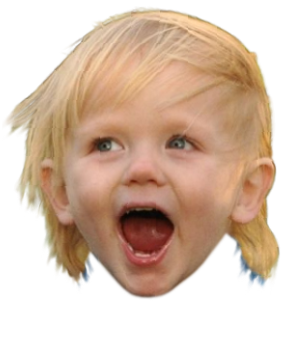

In [55]:
input_image_path = "divvyup_store/socks/600000/crop_of_subject"
# input_image_path = "model_staging/orientation/image_testing/humans/dat99.jpeg"
output = human_eyes(input_image_path)
output

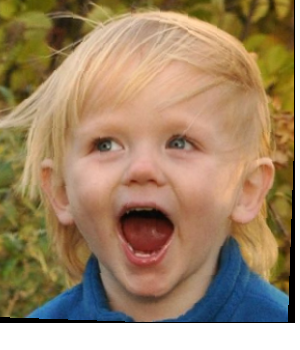

In [12]:
array_m = np.array(output)[:,:,:3]
Image.fromarray(array_m)

/home/ericd/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


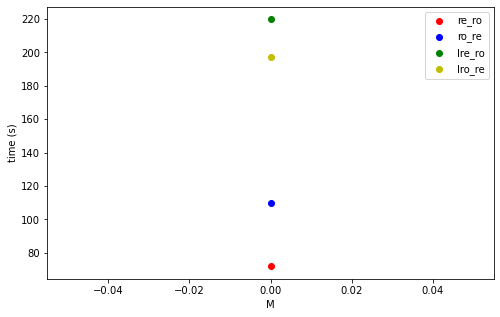

In [51]:
#Question: dilate vs rotate.
from skimage.transform import rescale, resize, rotate
from skimage.io import imread
%matplotlib inline
import matplotlib.pyplot as plt    
from timeit import Timer
def re_ro(image):
    h_im = 350
    w_im = 300
    for i in range(30):
        resized_cropT = resize(image, (h_im+i,h_im+i), anti_aliasing=True)
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, a/20 )*255
def lrero(image):
    h_im = 350
    w_im = 300
    [rotate(resize(image, (h_im+i,h_im+i), anti_aliasing=True)/255, a/20 )*255 for i in range(30) for a in range(-10,10)]
    
    
def ro_re(image):
    h_im = 350
    w_im = 300
    for a in range(-10,10):
        rot_cropT = rotate(image/255, a/20)*255    
        for i in range(30):
            resized_cropT = resize(rot_cropT, (h_im+i,h_im+i), anti_aliasing=True) 
def lrore(image):
    h_im = 350
    w_im = 300
    [resize(rotate(image, a/20 ), (h_im+i,h_im+i), anti_aliasing=True)/255*255 for a in range(-10,10) for i in range(30) ]
    
            
reps = 5
rd, dr, lrd, ldr = [], [], [], []
Ms = range(1)
output = imread("baby.png")
for _ in Ms:
    t = Timer(lambda: re_ro(output))
    rd.append(t.timeit(number=reps))
    t = Timer(lambda: ro_re(output))
    dr.append(t.timeit(number=reps))
    t = Timer(lambda: lrero(output))
    lrd.append(t.timeit(number=reps))
    t = Timer(lambda: lrore(output))
    ldr.append(t.timeit(number=reps))
    
fig , ax = plt.subplots(figsize=(8, 5))
ax.scatter(Ms, rd, c='r', label='re_ro')
ax.scatter(Ms, dr, c='b', label='ro_re')
ax.scatter(Ms, lrd, c='g', label='lre_ro')
ax.scatter(Ms, ldr, c='y', label='lro_re')
ax.set_xlabel('M')
ax.set_ylabel('time (s)')
ax.legend();    

In [52]:
print(rd, dr, lrd, ldr)

[71.81946012900153] [109.84010259599017] [219.7612666470086] [197.19490853499155]


In [ ]:
Given mask, we find a region round the head, using those coordinates, we crop on the output of rotation dilation and we only use convolution on that part

In [ ]:
#files mask, base
from skimage.transform import rescale, resize, rotate
from skimage import img_as_ubyte
from utils import minimum_bounding_box, crop_img_from_bbox
import cv2
def lap(image):
    rgb_org_im = img_as_ubyte(image)     
    origin = np.float32(cv2.cvtColor(rgb_org_im, cv2.COLOR_BGR2GRAY))
    origin_rows, origin_cols = origin.shape
    originL = cv2.Laplacian(origin, -1)
    return originL    
def get_filter_weights(image, center):
    h_im = 350
    w_im = 300
    vector=[]
    for i in range(30):
        resized_cropT = resize(image, (h_im+i,h_im+i), anti_aliasing=True)
        dcenter = int(i*center.real/300)+int(i*center.imag/350)*1j
        new_center = center + dcenter
        for a in range(-10,10):
            rot_cropT = rotate(resized_cropT/255, angle= a/20, center = (new_center.real, new_center.imag) )*255
            dx,dy = dcenter.real, dcenter.imag
            extended_bbox = max(0, y1-20+dcenter.imag), max(0, x1-30+dcenter.real), min(350, y2+20+dcenter.imag), min(300, x2+30+dcenter.real)
            original_crop = crop_img_from_bbox(rot_cropT, extended_bbox)
            vector.append(original_crop)
    shapes = np.array([_.shape for _ in vector])
    max_rows,max_cols = shapes[:,0].max(),shapes[:,1].max()
    print(max_rows,max_cols)
    arr = np.zeros([len(temp),max_rows,max_cols])
    for (i,_) in enumerate(shapes):
        arr[i,:_[0],:_[1]] = temp[i]
    filters = torch.Tensor(arr)
    return(shapes, filters.unsqueeze(1))


def secrec(org_image, center, mask):
    background = org_image[:,:,:3]
    min_bbox = minimum_bounding_box(mask[:,:,3], alpha=0, mode=0) #([y1,x1,y2,x2])#at this moment I also know the center of both images
    mask_crop = crop_img_from_bbox(mask[:,:,:3], min_bbox)
    #assuming the image doesnot needs rotation or dilation
    y1,x1,y2,x2 = min_bbox
    #get_filter_weights(image, center)
    shapes,filters_ = get_filter_weights(background, center)
    input_tensor = torch.Tensor(images.originL).unsqueeze(0).unsqueeze(0)

    if self.use_cuda:
        input_tensor = input_tensor.cuda(torch.device('cuda:'+self.which_cuda))
        out = conv2d(filters_.cuda(torch.device('cuda:'+self.which_cuda)),input_tensor,padding=0).cpu()
    else:
        out = conv2d(input_tensor,filters_,padding=0).cpu()
    print(out.shape)


In [ ]:
    #out = 
    cvals = out.squeeze().max(dim=2)[0].max(dim=1)[0].reshape([num_angles,num_scales]).t().numpy()

    time_elapse = time.time() - t0
    #print("time: {}".format(time.time()-t0))
    best_scale_ix,best_rotation_ix = np.where(cvals==np.max(cvals))
    best_scale,best_rotation = self.scale_iter[best_scale_ix[0]],self.angle_iter[best_rotation_ix[0]]

    return best_scale,best_rotation


In [25]:
array_m = np.array(output)[135:155,95:195,:3]
Image.fromarray(array_m)

In [30]:
import math
hight=20
width=100
angle = math.tan(hight/width)

In [31]:
angle

0.2027100355086725

In [32]:
2*angle

0.405420071017345

In [ ]:
translate h by 30 and v by 20 
rotate in 20 steps from +.2027 to -.2027

In [34]:
array_m = np.array(output)[135:155,95:125,:3]
Image.fromarray(array_m)

In [ ]:
dilate image to 30 pixels +  and  to 30  pixels less

In [ ]:
from skimage.transform import rescale, resize, rotate
from skimage.filters import laplace
h_im = crop.height
w_im = crop.width
#image should be two dim by now
for dscale in range(-30,30):
    for drot in np.linspace(-.2027, .2027, 20):
        resized_cropT = resize(crop, (w_im+dscale, h_im+dscale), anti_aliasing=True) 
        rot_cropT = rotate(resized_cropT/255, drot)*255
        Lcrop = laplace(image, ksize=3, mask=None)
        A = Lcrop
        b = []
        
        

def _get_filter(angle,scale):
    resized_cropT = resize(crop, (w_im+dscale, h_im+dscale), anti_aliasing=True) 
    #resized_crop_mask = cv2resize(crop_mask, None, fx=scale_factor*scale, fy=scale_factor*scale) 
    rot_cropT = rotate(resized_cropT/255, drot)*255
    min_bbox = minimum_bounding_box(rot_crop_mask,alpha=0,mode=0)
    rot_crop = crop_img_from_bbox(rot_crop,min_bbox)
    rot_crop_mask = crop_img_from_bbox(rot_crop_mask,min_bbox)

    rot_cropL = cv2Laplacian(rot_crop, -1)*rot_crop_mask
    #rot_cropL = rot_crop*rot_crop_mask
    return(rot_cropL)

temp = [ _get_filter(angle,scale) for angle in angle_iter 
        for scale in max_scale_iter]
shapes = np.array([_.shape for _ in temp])
max_rows,max_cols = shapes[:,0].max(),shapes[:,1].max()
print(max_rows,max_cols)
arr = np.zeros([len(temp),max_rows,max_cols])
for (i,_) in enumerate(shapes):
    arr[i,:_[0],:_[1]] = temp[i]        

In [56]:
import cv2

In [ ]:
 crop,crop_mask,cropC,originL,origin = images.crop,images.crop_mask,images.cropC,images.originL,images.origin
#conv1 = nn.Conv2d(1, 5, kernel_size=1, stride=1, padding=0,  bias=False)
#conv1.weight = torch.nn.Parameter(torch.ones((1, 1, 5)))
 
        convVal = -1
        initS = max(bestScale/2, bestScale-0.03)
        for best_scaleT in np.arange(initS,bestScale+.03,0.003):
            for best_rotationT in np.arange(bestRotation-1, bestRotation+1, .2):
                # rotate and resize images to correct rotation/scale
                resized_cropT = cv2.resize(crop, None, fx=best_scaleT, fy=best_scaleT) 
                resized_crop_maskT = cv2.resize(crop_mask, None, fx=best_scaleT, fy=best_scaleT) 
                crop_rowsT, crop_colsT = resized_cropT.shape
                # rotate
                #rot_crop,rot_crop_mask = rotate_cropped_images(resized_crop,resized_crop_mask,best_rotation)
                rot_cropT = rotate(resized_cropT/255,best_rotationT)*255
                rot_crop_maskT = rotate(resized_crop_maskT/255,best_rotationT)*255
                rot_cropT *= rot_crop_maskT
                # crop
                min_bboxT = minimum_bounding_box(rot_crop_maskT,alpha=0,mode=0)
                rot_cropT = crop_img_from_bbox(rot_cropT,min_bboxT)
                rot_crop_maskT = crop_img_from_bbox(rot_crop_maskT,min_bboxT)


                outT = apply_conv(originL,rot_cropT,rot_crop_maskT)
                # position 
                conv_valT = np.max(outT[:-rot_cropT.shape[0],:-rot_cropT.shape[1]])
                if conv_valT> convVal:
                    resized_cropC = cv2.resize(cropC, None, fx=best_scaleT, fy=best_scaleT) 
                    rot_cropC = rotate(resized_cropC/255,best_rotationT)*255
                    rot_cropCS = crop_img_from_bbox(rot_cropC,min_bboxT)
                    
                    out = outT
                    convVal = conv_valT
                    conv_val = conv_valT
                    
                    rot_crop = rot_cropT 
                    min_bbox = min_bboxT
                    best_rotation = best_rotationT
                    best_scale = best_scaleT
        loc = np.where(out == conv_val)

        assert len(loc[0]) == 1
        max_conv_loc = (loc[0][0], loc[1][0],
                                    loc[0][0]+rot_crop.shape[0],
                                    loc[1][0]+rot_crop.shape[1])

        #changes
        img_crop = crop_img_from_bbox(images.rgb_org_im,max_conv_loc)
        img_cropW = rot_cropC.copy()
        y1,x1,y2,x2 = min_bbox
        img_cropW[y1:y2,x1:x2] = img_crop
        img_cropW[:,:,3] = img_cropW[:,:,3]/255
        print('is any value of the mask below 0? {} '.format( np.any(img_cropW[:,:,3] <0 ) ))
        img_crowR = rotate(img_cropW/255,-best_rotation)*255
        candidate = cv2.resize(img_crowR, None, fx=1/best_scale, fy=1/best_scale)
        if candidate.shape != (350, 300, 4):
            background = images.rgb_org_im.copy()
            y,x,_ = candidate.shape
            y = min(350, y)
            x = min(300,x)
            background[:y,:x] =  candidate[:y,:x]
            candidate = background
        
        return candidate, max_conv_loc

Ill rewrite the code to make it easy to swich between images

In [ ]:
possible file structure:
    order_id
        [original image]
        line_id
            [final product]
            cropped
                [seems to have a mask]
            cropped_simple
                [seems it doesnt have a mask]
                
    
    

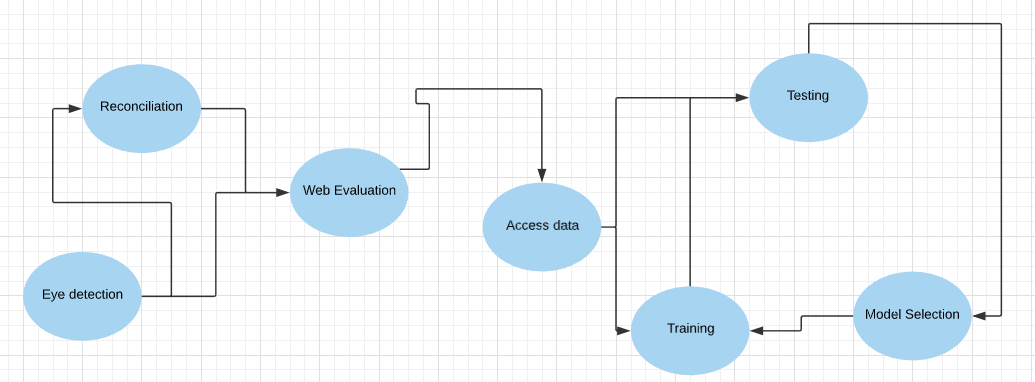

In [2]:
from IPython.display import Image as IpI
IpI("network.png")

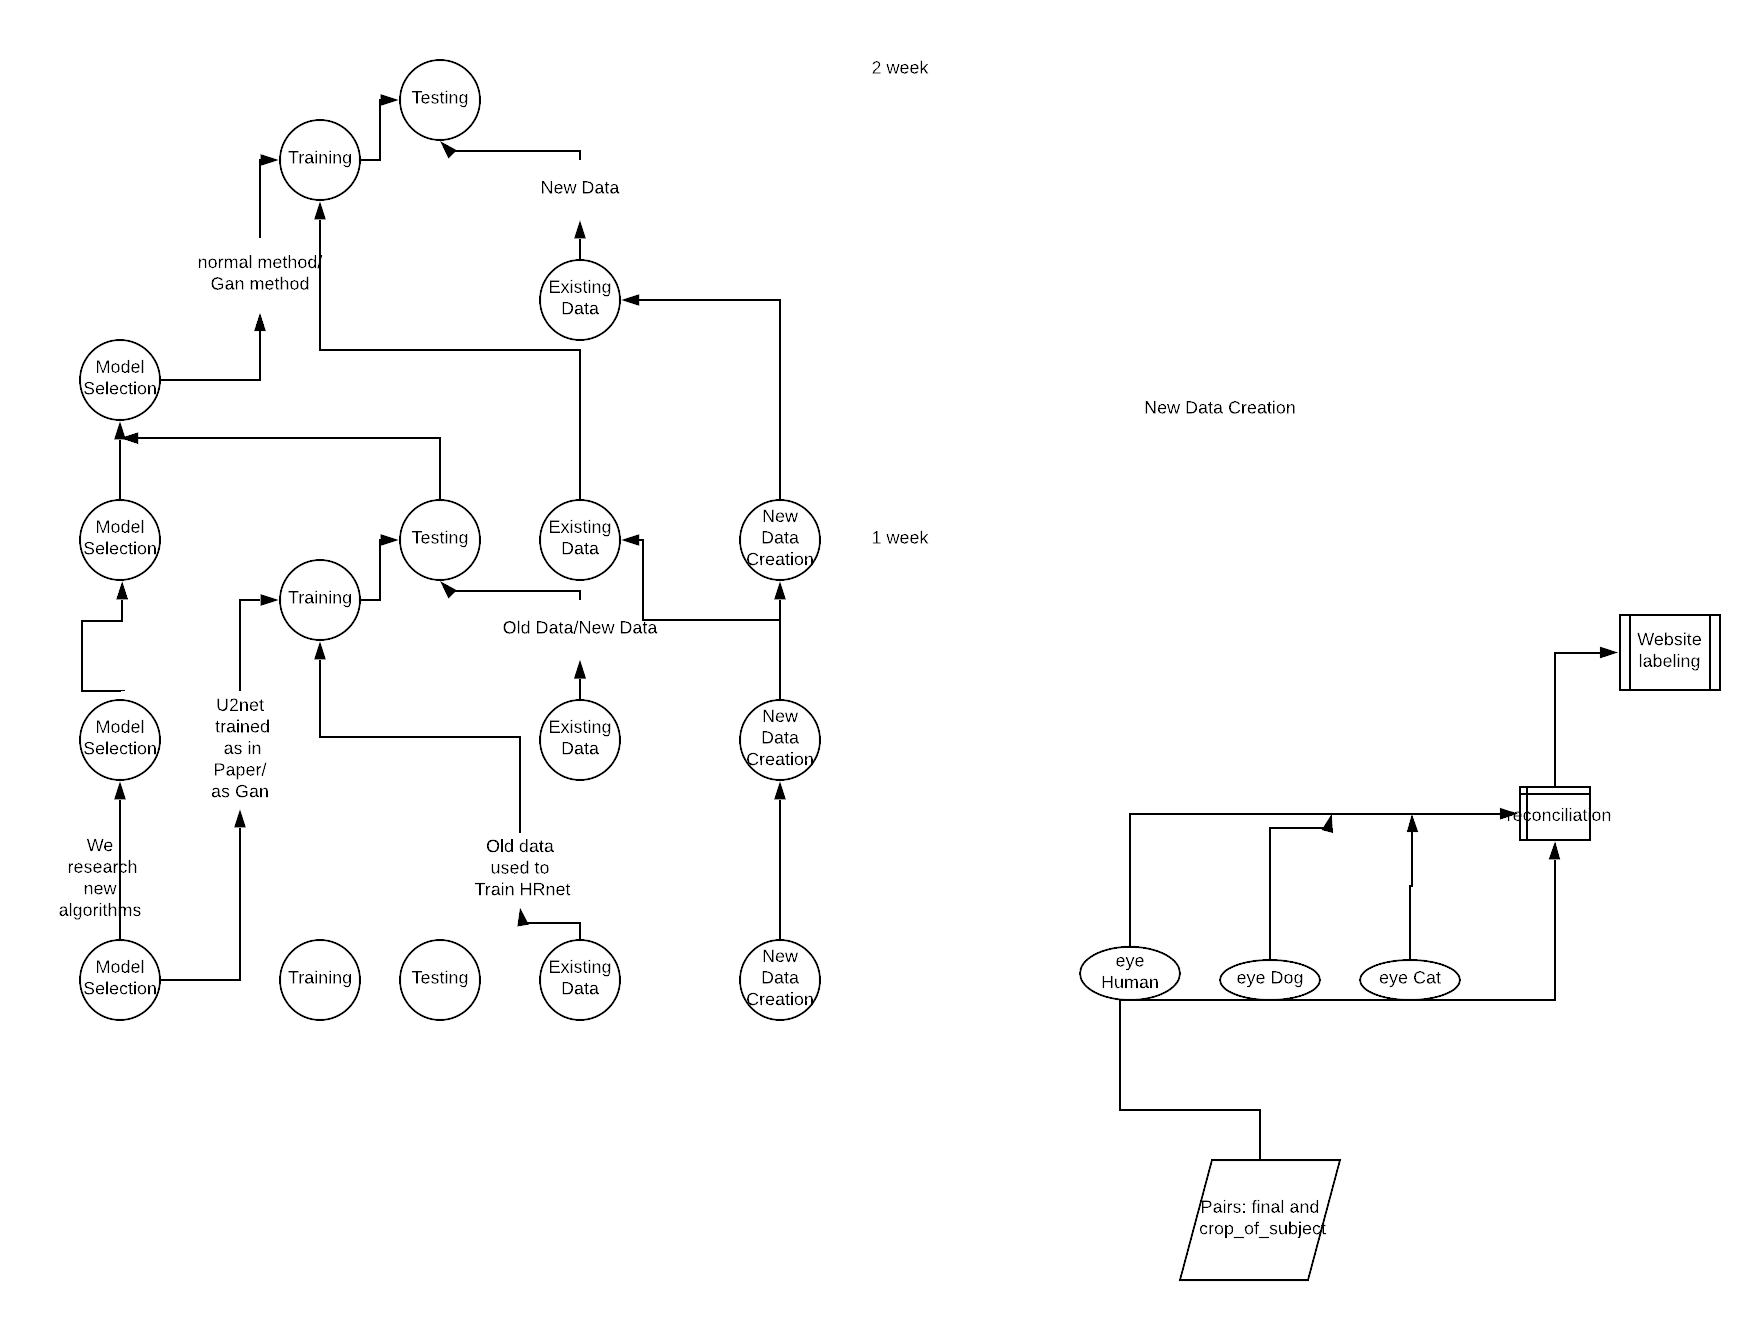

In [3]:

IpI("base_diagram.png")

In [ ]:
given a pair (input to automask, and final) we create 3 files:
    reconciliation with eyes
    nathan reconciliation
    eyes-nathan

In [4]:
import pandas as pd
# We have a csv of the masks that we labeled
db = pd.read_csv('mask_updates.csv')
# We need to find the crops needed 

In [5]:
db.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
3,/refined_masks/mask_images3/mask_images2/14389...,20270,143897,bad,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1


In [6]:
db.describe()

,order_id,line_item_id,number_of_heads
count,3937.000000,3937.000000,3937.000000
mean,24259.324867,146798.887986,1.023622
std,2371.191404,1674.872935,0.185064
min,20263.000000,143893.000000,0.000000
25%,22237.000000,145346.000000,1.000000
50%,24246.000000,146831.000000,1.000000
75%,26250.000000,148249.000000,1.000000
max,42819.000000,149631.000000,4.000000


In [ ]:
What data we used to train HRnet?
mask_updates.csv has those mask that we labeled. Where is the corresponding file?  
It is a crop done on the original image.






In [9]:
list(db.mask_of_subjects_face[:5])

['/refined_masks/mask_images3/mask_images2/143893-20263-1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.npy',
 '/refined_masks/mask_images3/mask_images2/143895-20265-1539834790-7-img-1144-01.npy',
 '/refined_masks/mask_images3/mask_images2/143896-20268-1539885630-90-img-0561.npy',
 '/refined_masks/mask_images3/mask_images2/143897-20270-1539886076-44-img-5953.npy',
 '/refined_masks/mask_images3/mask_images2/143900-20273-1539886709-49-linus.npy']

We take the first image, and we use the 	order_id	line_item_id	 to find the file divvyup-data/143893/20263/cropped

In [10]:
from PIL import Image
import numpy as np

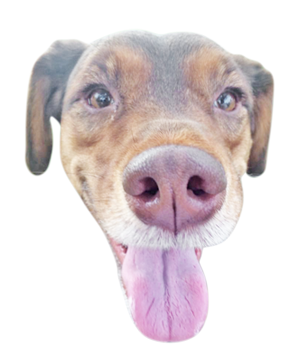

In [12]:
im = Image.open('figures/143893_20263_cropped_34781.png')
im

In [13]:
file = np.array(im)
file.shape

(350, 300, 4)

## This is a final image, not a crop

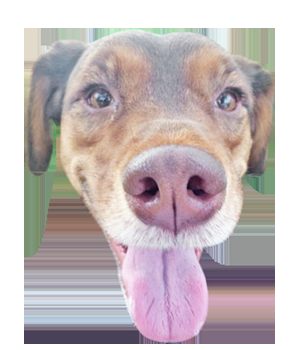

In [15]:
rgbfile=file[:,:,:3]
im2 = Image.fromarray(rgbfile)
im2

## This is an original image

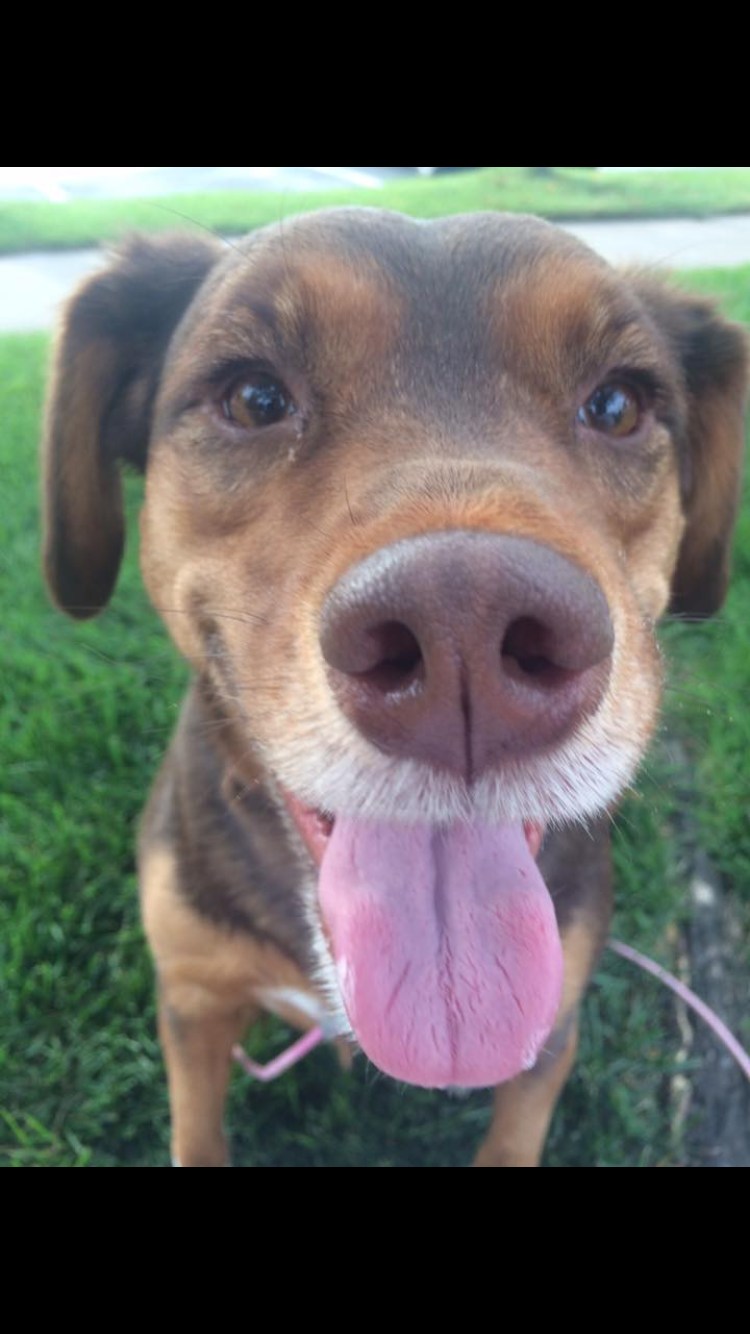

In [17]:
im3 = Image.open('figures/143893_1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.png')
im3

In [18]:
file = np.array(im3)
file.shape

(1334, 750, 4)

### Where are the crops for the old data that we labeled?

### Once we have the data, we can train U2NET https://github.com/NathanUA/U-2-Net/blob/master/model/u2net.py 

# creation of new data

In [ ]:
## We have an algorithm to detect eyes

https://github.com/johnmath/Laser_Eye_Dogs for dogs,
https://github.com/NewSciTLH/rotation_human/blob/master/cloudFunction/main.py for humans

original detectors
https://github.com/kairess/cat_hipsterizer
https://github.com/kairess/dog_face_detector
google vision API

Working Plan.

Two paths.




In [ ]:
Our new dataset is sufficiently different from the training dataset that a model performing on the old dataset may fail in our dataset. 

While we build the new dataset, we prepare the models.

First we take the data used to train the original model, and use it on u2net. We need to modify u2net and 

    - Modify u2net to use all 6 of it's channels (1~2 days).
    - Find training data (ask Eric).
    -- Train directly u2net (1~week).
    -- Train with pix2pix (1-2~ weeks  ask Ericd)

In parallel:

    -Research newer methods including updates to hrnet and smaller versions.

- Test on data similar to training data
- Test on newer data.
    
Estimated time to have both models trained (1~2 weeks).

### Data collection.
The new dataset has less noise as the images are centered around the face.

- Pair the final product and the crop of subject
- Use google's landmark, dog landmark[https://github.com/kairess/dog_face_detector] and  cat landmark[https://github.com/kairess/cat_hipsterizer] to create a first reconciliation based only on eyes.
- If needed, run reconciliation algorithm only for small dilations, and rotations.
- While U2net is being trained, evaluate the datasets created. 
- Train U2net on the new dataset, adding new data and evaluating performace.







'divvyup-data/newsci_dump-02082019.json' contains a json with one to one and many to one images
gs://newsci-lab-data/divvyup-json/mask_updates.csv contains mask that were reconciled by us, and we can trust
    can we run a u2net on them?
    can we run a u2net on them with pix2pix?
    

In [1]:
import pandas as pd

file = pd.read_csv('mask_updates.csv')    

In [2]:
file.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
3,/refined_masks/mask_images3/mask_images2/14389...,20270,143897,bad,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1


In [3]:
good = file[file.mask_quality=='good']

In [4]:
good.describe()

,order_id,line_item_id,number_of_heads
count,2825.000000,2825.000000,2825.000000
mean,24226.029735,146773.384071,1.014867
std,2372.631124,1666.266034,0.154461
min,20263.000000,143893.000000,0.000000
25%,22200.000000,145324.000000,1.000000
50%,24221.000000,146811.000000,1.000000
75%,26179.000000,148189.000000,1.000000
max,42819.000000,149631.000000,4.000000


In [5]:
good.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1
5,/refined_masks/mask_images3/mask_images2/14390...,20275,143902,good,human,1


In [7]:
good.mask_of_subjects_face[0]

'/refined_masks/mask_images3/mask_images2/143893-20263-1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.npy'

### On divvyup-data/line/orderid/cropped we can find the rgb files.
We grab them and test u2net on it.

In [11]:
json = pd.read_json('newsci_dump-02082019.json', dtype=True)

In [12]:
json.head()

,numPhotos,numHeads,data
0,409354,424575,"{'order_id': 142372, 'line_items': [{'line_ite..."
1,409354,424575,"{'order_id': 142373, 'line_items': [{'line_ite..."
2,409354,424575,"{'order_id': 142374, 'line_items': [{'line_ite..."
3,409354,424575,"{'order_id': 142375, 'line_items': [{'line_ite..."
4,409354,424575,"{'order_id': 142377, 'line_items': [{'line_ite..."


In [13]:
json.data[0]

{'order_id': 142372,
 'line_items': [{'line_item_id': 18186,
   'original_photos': ['142372/1539646443-68-img-0299.jpg',
    '142372/1539646443-63-img-20150315-153534.jpg',
    '142372/1539646443-68-pippy.png'],
   'approved_cropped_heads': ['142372/18186/cropped/30871',
    '142372/18186/cropped/30872',
    '142372/18186/cropped/30873']},
  {'line_item_id': 18187,
   'original_photos': ['142372/1539647680-19-img-0299.jpg',
    '142372/1539647680-34-img-20150315-153534.jpg',
    '142372/1539647680-4-pippy.png'],
   'approved_cropped_heads': ['142372/18187/cropped/30875',
    '142372/18187/cropped/30876',
    '142372/18187/cropped/30878']}]}

In [43]:
import json
# load data using Python JSON module
with open('newsci_dump-02082019.json','r') as f:
    stuff = json.loads(f.read())
# Flatten data
df_nested_list = pd.json_normalize(stuff, record_path =['data','line_items'])# we ignore order id

In [44]:
df_nested_list.head()

,line_item_id,original_photos,approved_cropped_heads
0,18186,"[142372/1539646443-68-img-0299.jpg, 142372/153...","[142372/18186/cropped/30871, 142372/18186/crop..."
1,18187,"[142372/1539647680-19-img-0299.jpg, 142372/153...","[142372/18187/cropped/30875, 142372/18187/crop..."
2,18188,[142373/1539648052-25-e4876618-3ddb-4da2-905a-...,[142373/18188/cropped/30865]
3,18189,[142374/1539648041-56-d5fde5db-87c2-42b6-b06a-...,[142374/18189/cropped/30869]
4,18190,[142374/1539648124-93-815b6acc-1b65-4c4d-8ab9-...,[142374/18190/cropped/30870]


In [45]:
assert len(df_nested_list)== len(df_nested_list.line_item_id.unique() )

In [46]:
 len(df_nested_list)

304431

In [47]:
assert len(good)== len(good.line_item_id.unique() )

AssertionError: 

In [48]:
 len(good)

2825

In [49]:
len(good.line_item_id.unique() )

2239

In [50]:
good[good.duplicated(['line_item_id'], keep=False)]

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
8,/refined_masks/mask_images3/mask_images2/14390...,20281,143906,good,dog,1
9,/refined_masks/mask_images3/mask_images2/14390...,20282,143906,good,dog,1
10,/refined_masks/mask_images3/mask_images2/14390...,20283,143906,good,cat,1
20,/refined_masks/mask_images3/mask_images2/14392...,20305,143922,good,dog,1
21,/refined_masks/mask_images3/mask_images2/14392...,20306,143922,good,dog,1
...,...,...,...,...,...,...
3915,/refined_masks/mask_images3/mask_images2/14960...,28272,149608,good,dog,1
3916,/refined_masks/mask_images3/mask_images2/14960...,28273,149608,good,dog,1
3917,/refined_masks/mask_images3/mask_images2/14960...,28274,149608,good,dog,1
3918,/refined_masks/mask_images3/mask_images2/14960...,28275,149609,good,dog,1


I want to remove those terms that have more than one entry

In [51]:
new_table =pd.concat(g for _, g in good.groupby('line_item_id') if len(g) == 1)

In [52]:
len(new_table)

1824

This are the initial images to run experiments, they are already aligned, with a perfect label, and ready to be used.

In [54]:
joined = pd.merge(df_nested_list,new_table, on='line_item_id')

In [55]:
len(joined)

1795

In [56]:
joined.describe()

,line_item_id,order_id,number_of_heads
count,1795.000000,1795.000000,1795.000000
mean,146722.295265,24161.810028,1.018384
std,1664.364038,2398.358989,0.157307
min,143893.000000,20263.000000,0.000000
25%,145281.500000,22144.000000,1.000000
50%,146715.000000,24122.000000,1.000000
75%,148178.000000,26158.000000,1.000000
max,149631.000000,42819.000000,3.000000


In [57]:
joined.head()

,line_item_id,original_photos,approved_cropped_heads,mask_of_subjects_face,order_id,mask_quality,subject_class,number_of_heads
0,146351,[170972/1542721060-91-patches-chain.jpg],[170972/146351/cropped/350398],/refined_masks/mask_images3/mask_images2/14635...,23619,good,human,1
1,143893,[235511/1547332561-50-20190107-194519.jpg],[235511/143893/cropped/259883],/refined_masks/mask_images3/mask_images2/14389...,20263,good,dog,1
2,143896,[235514/1547332856-99-71c10db1-2c86-491e-9ccd-...,[235514/143896/cropped/258606],/refined_masks/mask_images3/mask_images2/14389...,20268,good,dog,1
3,143900,[235517/1547332808-63-9c1cce09-3889-499e-ae12-...,[235517/143900/cropped/259885],/refined_masks/mask_images3/mask_images2/14390...,20273,good,cat,1
4,143902,[235519/1547333284-1-2706910a-e8d1-4dde-8faf-5...,[235519/143902/cropped/258610],/refined_masks/mask_images3/mask_images2/14390...,20275,good,human,1


In [58]:
joined.to_csv('dataset.csv')